# Gatos vs Perros

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("//content/drive/My Drive/proyectos/gatos y perros/")

# Check current working directory.
retval = os.getcwd()
print ("Current working directory %s" % retval)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory /content/drive/My Drive/proyectos/gatos y perros


### Introducción

* En este notebook vamos a realizar el clásico ejercicio de Deep Learning de un modelo capaz de identificar perros y gatos al pasarles una fotografía

* Como set de datos vamos a utilizar un conjunto de más de 1000 fotografías de cada animal divididos en conjuntos de entrenamiento, validación y test

* Características de cada conjunto:
    * Train: Conjunto de datos con los que se va a entrenar la red neuronal, esta compuesto por 1000 fotografías de perros y otras 1000 de gatos
    * Validation: Conjunto de datos para ir realizando validaciones durante el entrenamiento, esta compuesto por 342 imágenes de cada animal
    * Test: Conjunto para probar el modelo una vez entrenado, esta compuesto por 125 imágenes de cada animal

### Librerías

* En este ejercicio vamos a utilizar las siguientes librerías:
    * os: para trabajar con directorios
    * numpy: para realizar operaciones aritméticas
    * matplotlib: para la visualización de datos
    * cv2: para trabajar con imágenes
    * tensorflow: para trabajar con redes neuronales
    * json, sys: para el guardado de modelos
    * sklearn: para análisis de resultados

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dropout,Dense,MaxPool2D,Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
import json, sys
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
animales=os.listdir('./data/train')
animales

['perro', 'gato']

### Visualización

* En primer lugar vamos a visualizar una muestra de nuestros datos de entrenamiento, utilizaremos 5 fotos de gatos y 5 de perros 

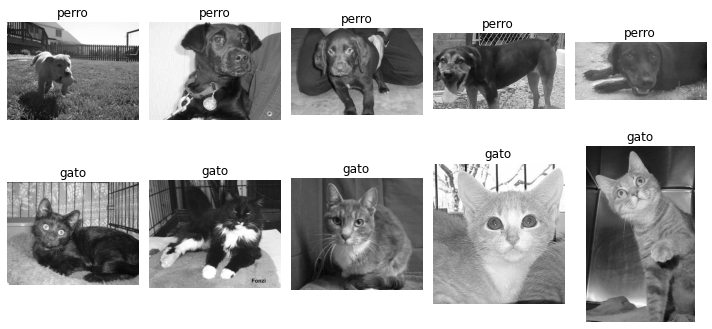

In [4]:
fig,ax=plt.subplots(2,5,figsize=(10,5))
r,c=(0,0)
for animal in animales:
    path='./data/train/'+animal
    muestra=os.listdir(path)
    muestra=muestra[:5]
    for image in muestra:
        img=cv2.imread(path+'/'+image,0)
        ax[r,c].imshow(img,cmap='gray')
        ax[r,c].axis('off')
        ax[r,c].set_title(animal)
        if c<4:
            c+=1
        else:
            c=0
            r+=1
plt.tight_layout()
plt.show() 

### Descarga de los datos

* Para la descarga de los datos vamos a utilizar data augmentation, de esta manera aumentaremos la cantidad de estos mediante copias ligeramente modificadas. En nuestro caso haremos lo siguiente:
    * Normalización: Vamos a dejar las imágenes en un rango entre 0 y 1 para facilitar la computación
    * Rotación: Vamos a rotar algunas imágenes aleatoriamente
    * Corte: Vamos a realizar cortes en algunas imágenes
    * Zoom: Vamos a ampliar algunas imágenes
    * Voltear imágenes
* El proceso de data augmentation lo vamos a realizar únicamente con el conjunto de datos de entrenamiento, para la validación tan sólo vamos a normalizar las imágenes
* Las fotografías de los animales las tomaremos de su directorio correspondiente, las vamos a cambiar el tamaño a 224x224 y se descargarán en lotes de 32 imágenes. También pasaremos las imágenes a escala de grises para un entrenamiento más rápido

In [5]:
path_train='./data/train'
path_val='./data/validation'

train_image=ImageDataGenerator(rescale=1./255,rotation_range=0.3,shear_range=0.3,
                               zoom_range=[0.5,1.5],horizontal_flip=True).flow_from_directory(path_train,target_size=(224,224),batch_size=32,class_mode='binary',color_mode='grayscale')

val_image=ImageDataGenerator(rescale=1./255).flow_from_directory(path_val,target_size=(224,224),batch_size=32,class_mode='binary',color_mode='grayscale')

Found 2006 images belonging to 2 classes.
Found 686 images belonging to 2 classes.


* Una vez descargadas las imágenes vamos a visualizar un lote de estas, donde podremos ver las transformaciones realizadas a los datos

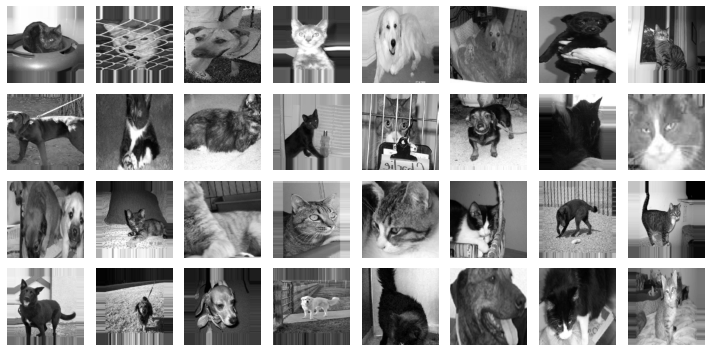

In [6]:
muestra=train_image[0][0]
fig,ax=plt.subplots(4,8,figsize=(10,5))
r,c=(0,0)
for imagen in muestra:
    ax[r,c].imshow(imagen[:,:,0],cmap='gray')
    ax[r,c].axis('off')
    if c<7:
        c+=1
    else:
        c=0
        r+=1
plt.tight_layout()
plt.show() 

### Red neuronal

* Vamos a pasar a la creación de nuestra red neuronal convolucional para la clasificación de perros y gatos

In [7]:
clf=Sequential()
clf.add(Conv2D(filters=32,kernel_size=(2,2),input_shape=(224,224,1),activation='relu',padding='same'))
clf.add(MaxPool2D(pool_size=(2,2)))
clf.add(Conv2D(filters=64,kernel_size=(2,2),activation='relu',padding='same'))
clf.add(MaxPool2D(pool_size=(2,2)))
clf.add(Conv2D(filters=128,kernel_size=(2,2),activation='relu',padding='same'))
clf.add(MaxPool2D(pool_size=(2,2)))
clf.add(Dropout(0.5))

clf.add(Flatten())
clf.add(Dense(256,activation='relu'))
clf.add(Dense(1,activation='sigmoid'))

* La red que hemos generado es bastante sencilla, vamos a visualizar su arquitectura

In [8]:
clf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

In [9]:
clf.compile(optimizer=Adam(lr=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


* En caso que el accuracy de la validación deje de mejorar durante un número de épocas vamos a reducir el learning rate, si pasan más épocas y todavía continúa sin mejorar se pasará a interrumpir el entrenamiento

In [10]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks=[early_stopping,lr_scheduler]

* Entrenaremos nuestro modelo con 50 épocas y después analizaremos los resultados

In [11]:
epocas=50
history=clf.fit(train_image,epochs=epocas,validation_data=val_image,callbacks=callbacks,batch_size=32,shuffle=True)

Epoch 1/50
63/63 [==============================] - 37s 490ms/step - loss: 0.6938 - accuracy: 0.5165 - val_loss: 0.6844 - val_accuracy: 0.5058 - lr: 1.0000e-04
Epoch 2/50
63/63 [==============================] - 25s 388ms/step - loss: 0.6889 - accuracy: 0.5419 - val_loss: 0.6804 - val_accuracy: 0.5802 - lr: 1.0000e-04
Epoch 3/50
63/63 [==============================] - 25s 391ms/step - loss: 0.6821 - accuracy: 0.5628 - val_loss: 0.6640 - val_accuracy: 0.6108 - lr: 1.0000e-04
Epoch 4/50
63/63 [==============================] - 25s 398ms/step - loss: 0.6627 - accuracy: 0.6022 - val_loss: 0.6560 - val_accuracy: 0.5743 - lr: 1.0000e-04
Epoch 5/50
63/63 [==============================] - 25s 393ms/step - loss: 0.6493 - accuracy: 0.6236 - val_loss: 0.6356 - val_accuracy: 0.6414 - lr: 1.0000e-04
Epoch 6/50
63/63 [==============================] - 25s 391ms/step - loss: 0.6441 - accuracy: 0.6186 - val_loss: 0.6126 - val_accuracy: 0.6822 - lr: 1.0000e-04
Epoch 7/50
63/63 [======================

* Al llegar a un punto en que no se llegaban a mejoras del accuracy de validación, en primer lugar se ha reducido el learning rate y después se ha interrumpido el entrenamiento
* Como podemos ver en el histórico los datos de validación no llegan a mejorar a los de entrenamiento, parece que nuestro modelo esté algo sobre-ajustado

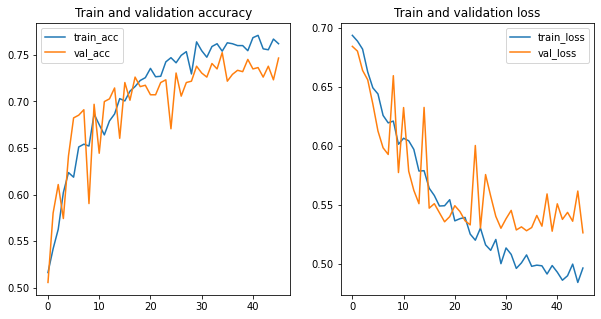

''

In [12]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epocas=range(len(acc))

fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].plot(epocas,acc,label='train_acc')
ax[0].plot(epocas,val_acc,label='val_acc')
ax[0].set_title('Train and validation accuracy')
ax[0].legend()

ax[1].plot(epocas,loss,label='train_loss')
ax[1].plot(epocas,val_loss,label='val_loss')
ax[1].set_title('Train and validation loss')
ax[1].legend()
plt.show()
;

* El siguiente paso consistirá en guardar los resultados obtenidos

In [13]:
model_path='./modelo'

if not os.path.exists(model_path):
  print('carpeta creada', model_path)
  os.makedirs(model_path)

In [14]:
#Guardado de modelo en json
clf_json=clf.to_json()
with open('modelo/gatos_perros_modelo.json','w') as json_file:
  json_file.write(clf_json)

#Guardado de pesos
clf.save_weights('modelo/gatos_perros_pesos.h5')

* Ahora crearemos un clasificador con la estructura del modelo anteriormente entrenado y sus pesos

In [15]:
file_model="./modelo/gatos_perros_modelo.json"
file_weights="./modelo/gatos_perros_pesos.h5"

In [16]:
json_file = open(file_model, 'r')
model_json = json_file.read()
json_file.close()
model = tf.keras.models.model_from_json(model_json)
model.load_weights(file_weights)

In [17]:
model.compile(optimizer=Adam(lr=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


* Vamos a pasar a probar nuestro modelo con el conjunto de datos de test, aunque visto el entrenamiento parece que los resultados no van a ser demasiado óptimos
* En primer lugar pasamos a descargar las imágenes de entrenamiento aplicandoles normalización y redimensionando su tamaño para que sean compatibles con el modelo creado

In [18]:
path_test='./data/test'
test_image=ImageDataGenerator(rescale=1./255).flow_from_directory(path_test,target_size=(224,224),batch_size=32,class_mode='binary',color_mode='grayscale')

Found 250 images belonging to 2 classes.


* Vamos a pasar a visualizar un lote del conjunto de test

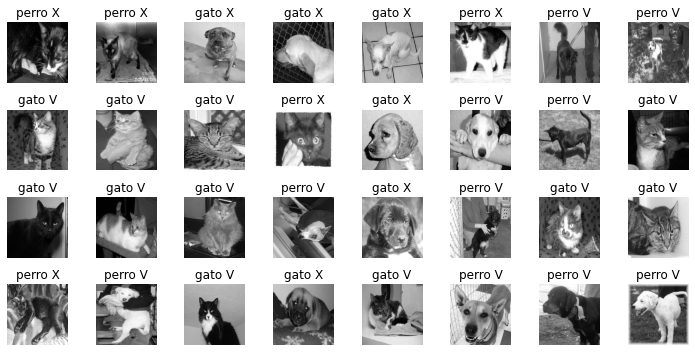

In [19]:
muestra=test_image[0][0]
real_label=test_image[0][1]
fig,ax=plt.subplots(4,8,figsize=(10,5))
r,c,i=(0,0,0)
for imagen in muestra:
    ax[r,c].imshow(imagen[:,:,0],cmap='gray')
    imagen=np.expand_dims(imagen,axis=0)
    pred=np.rint(model.predict(imagen))
    if pred==0:
      pred_label='gato'
    else:
      pred_label='perro'
    if real_label[i]==pred:
      result='V'
    else:
      result='X'
    ax[r,c].set_title('{} {}'.format(pred_label,result))
    ax[r,c].axis('off')
    if c<7:
        c+=1
    else:
        c=0
        r+=1
    i+=1
plt.tight_layout()
plt.show() 


* Como podemos observar algunas imágenes las reconoce bien mientras que se confunde en otras
* Pasaremos ahora a realizar la predicción de todo el conjunto y a evaluar los resultados

In [20]:
prediccion=model.predict(test_image)

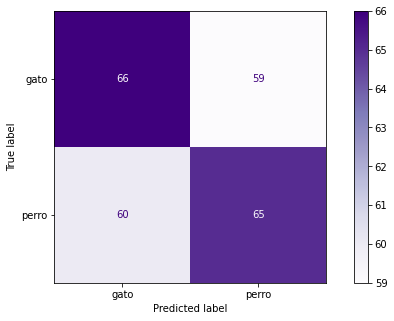

In [21]:
clases=['gato','perro']
test_pred=np.rint(prediccion)
cm = confusion_matrix(test_image.classes,test_pred)
fig, ax = plt.subplots(figsize=(10, 5))
cmd = ConfusionMatrixDisplay(cm, display_labels=clases)
cmd.plot(ax=ax,cmap='Purples');

In [22]:
print(classification_report(test_image.classes, test_pred, target_names=clases))

              precision    recall  f1-score   support

        gato       0.52      0.53      0.53       125
       perro       0.52      0.52      0.52       125

    accuracy                           0.52       250
   macro avg       0.52      0.52      0.52       250
weighted avg       0.52      0.52      0.52       250



* Tras observar la matriz de confusión y las métricas podemos asegurar que nuestro modelo padece sobre-entrenamiento
* Como soluciones podríamos probar a utilizar algún modelo pre-entrenado o realizar modificaciones en la arquitectura de nuestra red para ver si se mejoran los resultado obtenidos